In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nepali-handwritten-digits/train_digits_data.csv
/kaggle/input/nepali-handwritten-digits/test_digits_data.csv


In [2]:
train_digits = pd.read_csv("/kaggle/input/nepali-handwritten-digits/train_digits_data.csv")
test_digits = pd.read_csv("/kaggle/input/nepali-handwritten-digits/test_digits_data.csv")

In [3]:
train_digits.head()

pixel_0000  pixel_0001  pixel_0002  pixel_0003  pixel_0004  pixel_0005  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   pixel_0006  pixel_0007  pixel_0008  pixel_0009  ...  pixel_1015  \
0           0           0           0           0  ...           0   
1           0           0           0           0  ...           0   
2           0           0           0           0  ...           0   
3           0           0           0           0  ...           0   
4           0           0           0           0  ...           0   

   pixel_1016  pixel_1017  pixel_1018  pixel_1019  pixel_1020  pixel_1021  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   pixel_1022  pixel_1023  character  
0           0           0    digit_0  
1           0           0    digit_0  
2           0           0    digit_0  
3           0           0    digit_0  
4           0           0    digit_0  

[5 rows x 1025 columns]

In [4]:
train_digits['character'].value_counts()

character
digit_0    1700
digit_1    1700
digit_2    1700
digit_3    1700
digit_4    1700
digit_5    1700
digit_6    1700
digit_7    1700
digit_8    1700
digit_9    1700
Name: count, dtype: int64

In [5]:
img_1 = train_digits.loc[0,:]

In [6]:
img_1

pixel_0000          0
pixel_0001          0
pixel_0002          0
pixel_0003          0
pixel_0004          0
               ...   
pixel_1020          0
pixel_1021          0
pixel_1022          0
pixel_1023          0
character     digit_0
Name: 0, Length: 1025, dtype: object

In [7]:
pixels = img_1[:-1].astype(np.uint8).values
image = pixels.reshape((32,32))

In [8]:
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

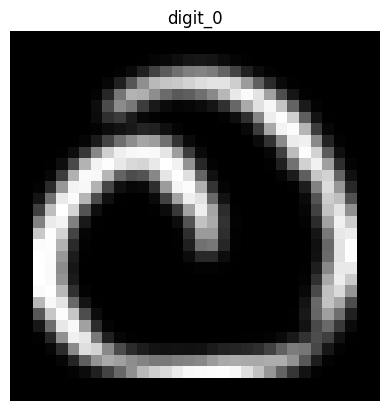

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming img_1 is a row from a DataFrame and contains 1024 pixel values + 1 label
pixels = img_1[:-1].astype(np.uint8).values  # Exclude the label and convert to int
image = pixels.reshape((32, 32))  # Reshape to 32x32

plt.imshow(image, cmap='gray')  # Display the image in grayscale
plt.title(img_1['character'])   # Show the label as title
plt.axis('off')                 # Hide axis
plt.show()


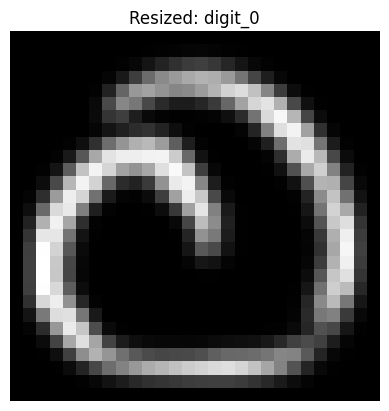

In [10]:
import cv2

image_28x28 = cv2.resize(image,(28,28),interpolation = cv2.INTER_AREA)
# Display the resized image
plt.imshow(image_28x28, cmap='gray')
plt.title(f"Resized: {img_1['character']}")
plt.axis('off')
plt.show()

In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader,ConcatDataset
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image,make_grid

In [12]:
class DigitCSVLoader(Dataset):
    def __init__(self,csv_path,transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

        # Mapping labels like digit_0  to integer 0
        self.label_map = {f"digit_{i}": i for i in range(10)}
        self.labels = self.df["character"].map(self.label_map).values
        self.images = self.df.drop(columns=["character"]).values.astype(np.uint8)

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        img_array = self.images[idx].reshape(32,32)
        img = Image.fromarray(img_array,mode='L') # grayscale image

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [13]:
def load_custom_dataset(train_csv,test_csv,img_size=28,batch_size=64):
    data_transforms = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(), # Converts [0-255] to [0,1] and adds channel dim
    ])

    train_set = DigitCSVLoader(train_csv,transform=data_transforms)
    test_set = DigitCSVLoader(test_csv,transform=data_transforms)

    full_dataset = ConcatDataset([train_set,test_set])
    dataloader = DataLoader(full_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
    return full_dataset,dataloader

In [14]:
data,dataloader = load_custom_dataset("/kaggle/input/nepali-handwritten-digits/train_digits_data.csv","/kaggle/input/nepali-handwritten-digits/test_digits_data.csv",img_size=28,batch_size=64)

In [15]:
data

In [16]:
dataloader

In [17]:
IMG_CH = 1
N_CLASSES = 10
IMG_SIZE = 28

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start,B_end,T).to(device)

In [20]:
print(B)

tensor([1.0000e-04, 2.3356e-04, 3.6711e-04, 5.0067e-04, 6.3423e-04, 7.6779e-04,
        9.0134e-04, 1.0349e-03, 1.1685e-03, 1.3020e-03, 1.4356e-03, 1.5691e-03,
        1.7027e-03, 1.8362e-03, 1.9698e-03, 2.1034e-03, 2.2369e-03, 2.3705e-03,
        2.5040e-03, 2.6376e-03, 2.7711e-03, 2.9047e-03, 3.0383e-03, 3.1718e-03,
        3.3054e-03, 3.4389e-03, 3.5725e-03, 3.7060e-03, 3.8396e-03, 3.9732e-03,
        4.1067e-03, 4.2403e-03, 4.3738e-03, 4.5074e-03, 4.6409e-03, 4.7745e-03,
        4.9081e-03, 5.0416e-03, 5.1752e-03, 5.3087e-03, 5.4423e-03, 5.5758e-03,
        5.7094e-03, 5.8430e-03, 5.9765e-03, 6.1101e-03, 6.2436e-03, 6.3772e-03,
        6.5107e-03, 6.6443e-03, 6.7779e-03, 6.9114e-03, 7.0450e-03, 7.1785e-03,
        7.3121e-03, 7.4456e-03, 7.5792e-03, 7.7128e-03, 7.8463e-03, 7.9799e-03,
        8.1134e-03, 8.2470e-03, 8.3805e-03, 8.5141e-03, 8.6477e-03, 8.7812e-03,
        8.9148e-03, 9.0483e-03, 9.1819e-03, 9.3154e-03, 9.4490e-03, 9.5826e-03,
        9.7161e-03, 9.8497e-03, 9.9832e-

In [21]:
a = 1.0 - B
a_bar = torch.cumprod(a,dim=0)
sqrt_a_bar = torch.sqrt(a_bar)
sqrt_one_minus_a_bar = torch.sqrt(1-a_bar)

sqrt_a_inv = torch.sqrt(1/a)
pred_noise_coeff = (1-a) / torch.sqrt(1-a_bar)

In [22]:
def q(x_0, t):
        t = t.int()
        noise = torch.randn_like(x_0)
        sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
        sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

        x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
        return x_t, noise

In [23]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

def save_animation(xs, gif_name, interval=300, repeat_delay=5000):
    fig = plt.figure()
    plt.axis('off')
    imgs = []

    for x_t in xs:
        im = plt.imshow(x_t, animated=True)
        imgs.append([im])

    animate = animation.ArtistAnimation(fig, imgs, interval=interval, repeat_delay=repeat_delay)
    animate.save(gif_name)


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))
    

def to_image(tensor, to_pil=True):
    tensor = (tensor + 1) / 2
    ones = torch.ones_like(tensor)
    tensor = torch.min(torch.stack([tensor, ones]), 0)[0]
    zeros = torch.zeros_like(tensor)
    tensor = torch.max(torch.stack([tensor, zeros]), 0)[0]
    if not to_pil:
        return tensor
    return transforms.functional.to_pil_image(tensor)


def plot_generated_images(noise, result):
    plt.figure(figsize=(8,8))
    nrows = 1
    ncols = 2
    samples = {
        "Noise" : noise,
        "Generated Image" : result
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

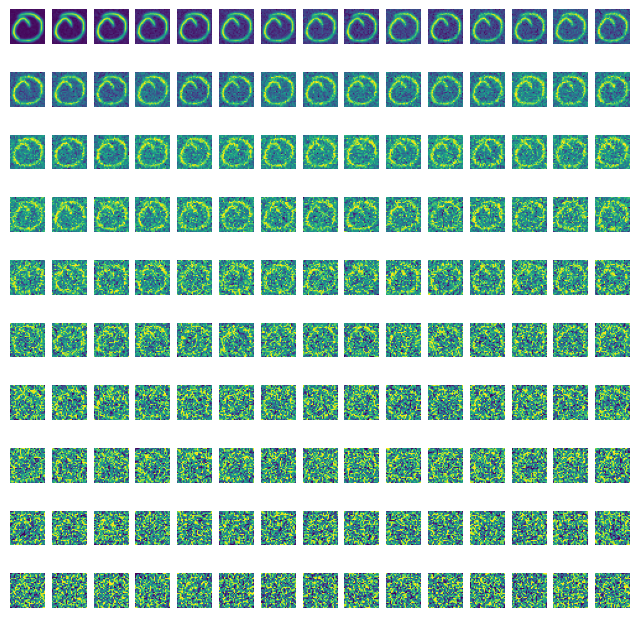

In [24]:
from PIL import Image

plt.figure(figsize=(8, 8))
x_0 = data[1][0].to(device)
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    show_tensor_image(x_t)

In [25]:
@torch.no_grad()
def reverse_q(x_t,t,e_t):
    t = t.int()
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t[0] == 0:
        return u_t
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [26]:
class UNet(nn.Module):
    def __init__(
        self, T, img_ch, img_size, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=10
    ):
        super().__init__()
        self.T = T
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)
        return self.out(torch.cat((up2, down0), 1))

In [27]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [28]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [29]:
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [30]:
from einops.layers.torch import Rearrange

class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [31]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [32]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [33]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [34]:
model = UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2547457


In [35]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [36]:
def get_loss(model, x_0, t, *model_args):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t/T, *model_args)
    return F.mse_loss(noise, noise_pred)

In [37]:
def sample_images(model, img_ch, img_size, ncols, *model_args, axis_on=False):
    # Noise to generate images from
    x_t = torch.randn((1, img_ch, img_size, img_size), device=device)
    plt.figure(figsize=(8, 8))
    hidden_rows = T / ncols
    plot_number = 1

    # Go from T to 0 removing and adding noise until t = 0
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device).float()
        e_t = model(x_t, t, *model_args)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            if not axis_on:
                ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

W0522 18:02:33.000000 19 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 0 | Step 000 | Loss: 1.105682611465454 | C: 0


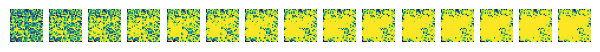

Epoch 0 | Step 100 | Loss: 0.0968959853053093 | C: 1


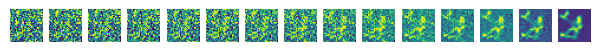

Epoch 0 | Step 200 | Loss: 0.05320422351360321 | C: 2


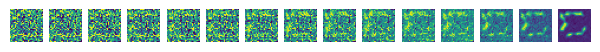

Epoch 0 | Step 300 | Loss: 0.06148992106318474 | C: 3


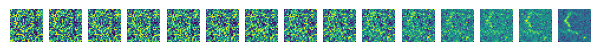

Epoch 1 | Step 000 | Loss: 0.06307542324066162 | C: 4


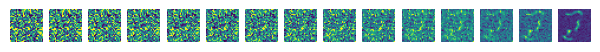

Epoch 1 | Step 100 | Loss: 0.05118408799171448 | C: 5


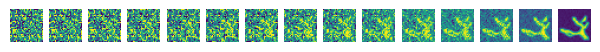

Epoch 1 | Step 200 | Loss: 0.05382784828543663 | C: 6


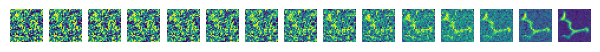

Epoch 1 | Step 300 | Loss: 0.048471804708242416 | C: 7


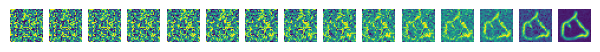

Epoch 2 | Step 000 | Loss: 0.0627710148692131 | C: 8


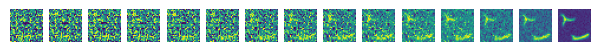

Epoch 2 | Step 100 | Loss: 0.04190591350197792 | C: 9


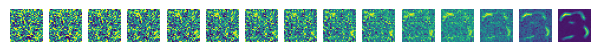

Epoch 2 | Step 200 | Loss: 0.04187387228012085 | C: 0


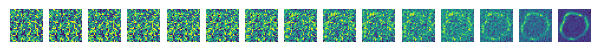

Epoch 2 | Step 300 | Loss: 0.04316423460841179 | C: 1


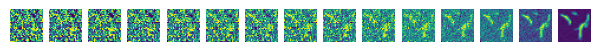

Epoch 3 | Step 000 | Loss: 0.05595867708325386 | C: 2


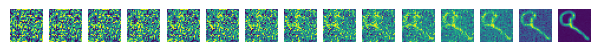

Epoch 3 | Step 100 | Loss: 0.048136692494153976 | C: 3


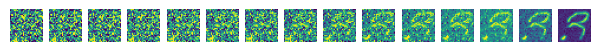

Epoch 3 | Step 200 | Loss: 0.04156564921140671 | C: 4


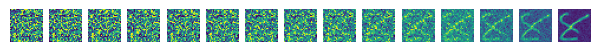

Epoch 3 | Step 300 | Loss: 0.04869476705789566 | C: 5


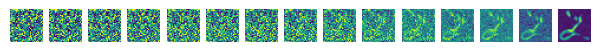

Epoch 4 | Step 000 | Loss: 0.043050143867731094 | C: 6


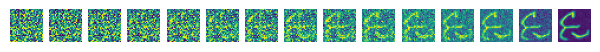

Epoch 4 | Step 100 | Loss: 0.04509372636675835 | C: 7


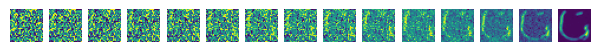

Epoch 4 | Step 200 | Loss: 0.04478609189391136 | C: 8


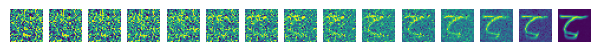

Epoch 4 | Step 300 | Loss: 0.030895423144102097 | C: 9


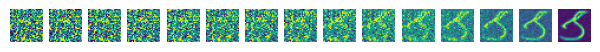

Epoch 5 | Step 000 | Loss: 0.03886076807975769 | C: 0


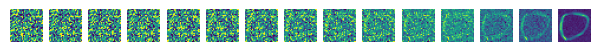

Epoch 5 | Step 100 | Loss: 0.031440503895282745 | C: 1


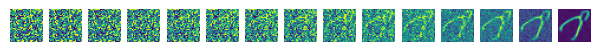

Epoch 5 | Step 200 | Loss: 0.039420612156391144 | C: 2


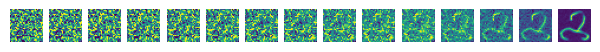

Epoch 5 | Step 300 | Loss: 0.03754067420959473 | C: 3


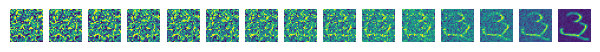

Epoch 6 | Step 000 | Loss: 0.038634948432445526 | C: 4


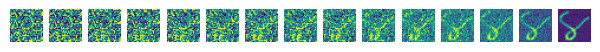

Epoch 6 | Step 100 | Loss: 0.0410701259970665 | C: 5


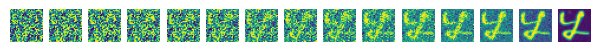

Epoch 6 | Step 200 | Loss: 0.03545259311795235 | C: 6


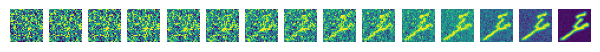

Epoch 6 | Step 300 | Loss: 0.039290450513362885 | C: 7


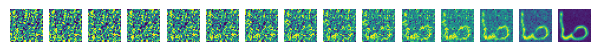

Epoch 7 | Step 000 | Loss: 0.037353917956352234 | C: 8


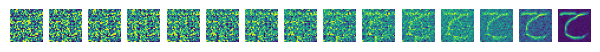

Epoch 7 | Step 100 | Loss: 0.05572060868144035 | C: 9


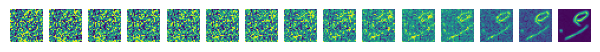

Epoch 7 | Step 200 | Loss: 0.04274855554103851 | C: 0


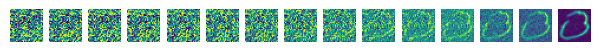

Epoch 7 | Step 300 | Loss: 0.04782289266586304 | C: 1


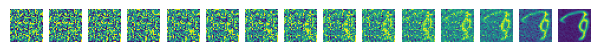

Epoch 8 | Step 000 | Loss: 0.052409812808036804 | C: 2


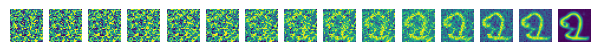

Epoch 8 | Step 100 | Loss: 0.03878334164619446 | C: 3


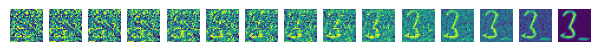

Epoch 8 | Step 200 | Loss: 0.0474163256585598 | C: 4


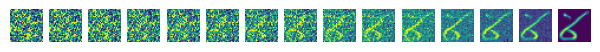

Epoch 8 | Step 300 | Loss: 0.03145698457956314 | C: 5


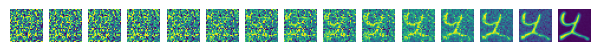

Epoch 9 | Step 000 | Loss: 0.03425414487719536 | C: 6


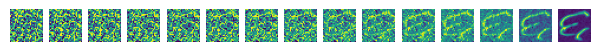

Epoch 9 | Step 100 | Loss: 0.03928176686167717 | C: 7


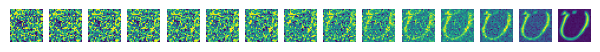

Epoch 9 | Step 200 | Loss: 0.030071601271629333 | C: 8


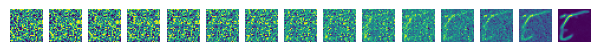

Epoch 9 | Step 300 | Loss: 0.03429111838340759 | C: 9


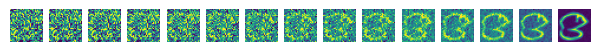

Epoch 10 | Step 000 | Loss: 0.031034812331199646 | C: 0


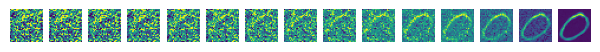

Epoch 10 | Step 100 | Loss: 0.03543839231133461 | C: 1


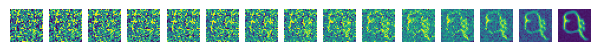

Epoch 10 | Step 200 | Loss: 0.03200829029083252 | C: 2


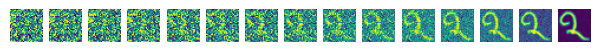

Epoch 10 | Step 300 | Loss: 0.028467761352658272 | C: 3


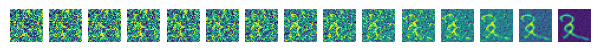

Epoch 11 | Step 000 | Loss: 0.04289355129003525 | C: 4


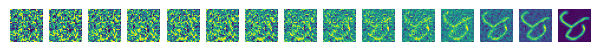

Epoch 11 | Step 100 | Loss: 0.03500747308135033 | C: 5


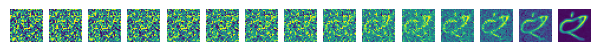

Epoch 11 | Step 200 | Loss: 0.033940382301807404 | C: 6


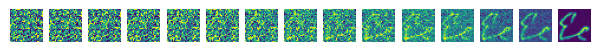

Epoch 11 | Step 300 | Loss: 0.03690820187330246 | C: 7


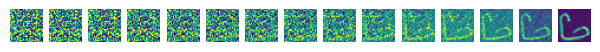

Epoch 12 | Step 000 | Loss: 0.041718821972608566 | C: 8


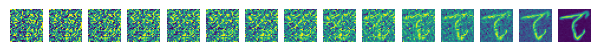

Epoch 12 | Step 100 | Loss: 0.03940832242369652 | C: 9


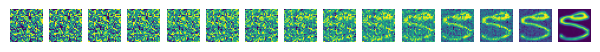

Epoch 12 | Step 200 | Loss: 0.03782908618450165 | C: 0


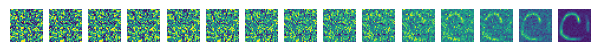

Epoch 12 | Step 300 | Loss: 0.03849082812666893 | C: 1


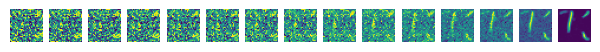

Epoch 13 | Step 000 | Loss: 0.04291868954896927 | C: 2


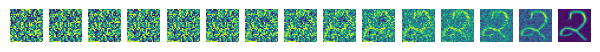

Epoch 13 | Step 100 | Loss: 0.032635193318128586 | C: 3


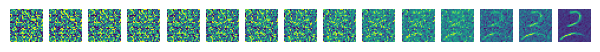

Epoch 13 | Step 200 | Loss: 0.03389447182416916 | C: 4


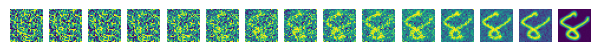

Epoch 13 | Step 300 | Loss: 0.03295296058058739 | C: 5


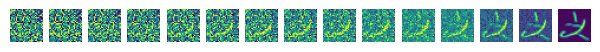

Epoch 14 | Step 000 | Loss: 0.03262212872505188 | C: 6


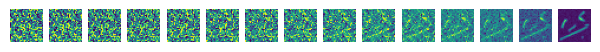

Epoch 14 | Step 100 | Loss: 0.04061189293861389 | C: 7


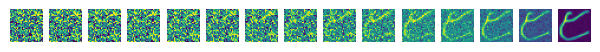

Epoch 14 | Step 200 | Loss: 0.03383322432637215 | C: 8


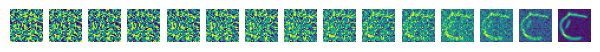

Epoch 14 | Step 300 | Loss: 0.04430723190307617 | C: 9


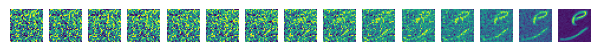

Epoch 15 | Step 000 | Loss: 0.030434943735599518 | C: 0


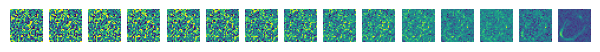

Epoch 15 | Step 100 | Loss: 0.03498753532767296 | C: 1


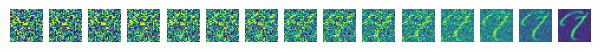

Epoch 15 | Step 200 | Loss: 0.032148923724889755 | C: 2


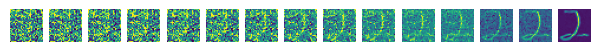

Epoch 15 | Step 300 | Loss: 0.0374731607735157 | C: 3


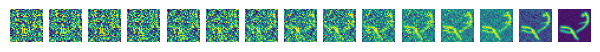

Epoch 16 | Step 000 | Loss: 0.03567980229854584 | C: 4


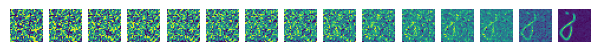

Epoch 16 | Step 100 | Loss: 0.030218783766031265 | C: 5


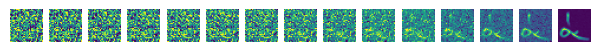

Epoch 16 | Step 200 | Loss: 0.03373151272535324 | C: 6


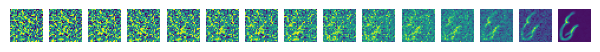

Epoch 16 | Step 300 | Loss: 0.03232334181666374 | C: 7


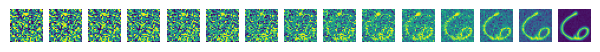

Epoch 17 | Step 000 | Loss: 0.0350959375500679 | C: 8


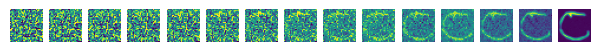

Epoch 17 | Step 100 | Loss: 0.03820803016424179 | C: 9


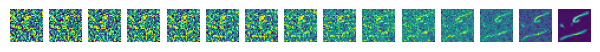

Epoch 17 | Step 200 | Loss: 0.03551717847585678 | C: 0


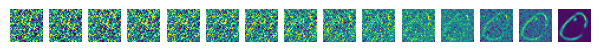

Epoch 17 | Step 300 | Loss: 0.03668668866157532 | C: 1


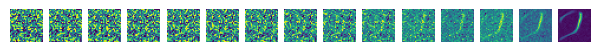

Epoch 18 | Step 000 | Loss: 0.030219456180930138 | C: 2


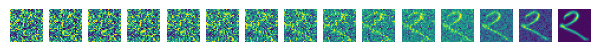

Epoch 18 | Step 100 | Loss: 0.03900192677974701 | C: 3


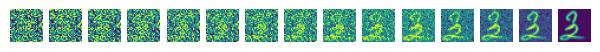

Epoch 18 | Step 200 | Loss: 0.03803374618291855 | C: 4


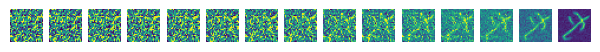

Epoch 18 | Step 300 | Loss: 0.02804119512438774 | C: 5


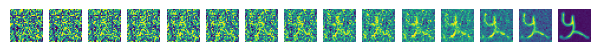

Epoch 19 | Step 000 | Loss: 0.0269265566021204 | C: 6


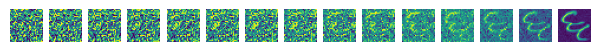

Epoch 19 | Step 100 | Loss: 0.041235897690057755 | C: 7


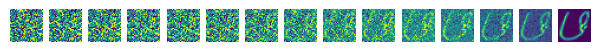

Epoch 19 | Step 200 | Loss: 0.03292102366685867 | C: 8


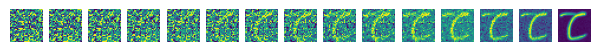

Epoch 19 | Step 300 | Loss: 0.03236399218440056 | C: 9


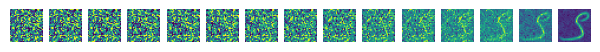

In [38]:
from torch.optim import Adam
import math
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 20
preview_c = 0
BATCH_SIZE = 64

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {preview_c}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES